In [350]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import matplotlib.colors as colors
import multiprocessing
import warnings

from nanonets.utils import BLUE_COLOR, RED_COLOR
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull, KDTree
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
from tqdm import tqdm
from scipy.optimize import curve_fit

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="seaborn"
)

plt.style.use(["science","bright","grid"])
# PATH    = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/freq_manipulation/"
PATH    = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/f0_1/"

# PATH_R  = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/res_disorder_freq_manipulation/"
PATH_R  = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/res_disorder_freq_manipulation/"

In [ ]:
def extract_harmonic_features(y_val, n_vals, N_periods=20, search_range=3, mode='complex', pad_len=None, interpolate=True):
    """
    Extracts harmonic features from a time series using FFT with optional zero-padding
    and parabolic interpolation for high-precision peak estimation.

    Parameters
    ----------
    y_val : array-like
        Input time series (e.g., current or voltage).
    n_vals : list or array-like of int
        List of harmonic orders to extract (e.g., [1, 2, 3] or [3, 5, 7]).
    N_periods : float, optional (default=20)
        Number of full periods of the fundamental frequency contained in y_val.
        Used to identify the theoretical FFT bin index of the fundamental.
    search_range : int, optional (default=3)
        Number of FFT bins to search left/right of the ideal index to account for 
        spectral leakage or small frequency deviations.
    mode : str, optional (default='complex')
        Format of the output features:
        - 'complex':   [Re, Im] pairs relative to fundamental phase. (Length = 2 * len(n_vals))
                       Preserves full shape info; ideal for Volumetric analysis.
        - 'abs':       [Magnitude] only. (Length = len(n_vals))
                       Ideal for THD or Centroid analysis.
        - 'projected': [Magnitude * cos(delta_phi)]. (Length = len(n_vals))
                       Scalar projection onto fundamental axis (lossy).
        - 'phase':     [Phase Difference] in normalized radians/pi [-1, 1].
    pad_len : int or None, optional (default=None)
        Length of the FFT padding. If None, uses len(y_val). 
        Higher values (e.g., 4096) increase spectral density, reducing discretization error.
    interpolate : bool, optional (default=True)
        If True, uses parabolic interpolation on the spectral peak to estimate 
        magnitude and frequency more accurately than the discrete FFT bin resolution.
        Recommended to avoid "bimodality" in error distributions.

    Returns
    -------
    np.ndarray
        Array of feature values. Structure and length depend on 'mode'.
    """
    
    # --- 1. Preprocessing: Detrend and Window ---
    y_val = np.array(y_val)
    # Remove DC offset to prevent 0-Hz peak leakage
    y_val = y_val - np.mean(y_val)
    
    N_samples = len(y_val)
    
    # Blackman window minimizes spectral leakage (low sidelobes)
    window = np.blackman(N_samples)
    y_windowed = y_val * window
    
    # Coherent Gain Correction: compensates for energy amplitude lost due to windowing
    w_gain = np.sum(window) / N_samples
    
    # --- 2. FFT Calculation ---
    # Determine padding
    if pad_len is None:
        n_fft = N_samples
        pad_ratio = 1.0
    else:
        n_fft = pad_len
        pad_ratio = n_fft / N_samples
    
    # rfft is efficient for real-valued inputs; returns positive freqs only
    fft_vals = np.fft.rfft(y_windowed, n=n_fft)

    # Helper: Peak Extraction Logic
    def get_peak_metrics(neighborhood):
        """
        Internal helper to find peak magnitude and phase from a spectral slice.
        Handles both discrete argmax and parabolic interpolation.
        """
        # Safety check for empty or zero-signal neighborhoods
        if len(neighborhood) == 0 or np.max(np.abs(neighborhood)) < 1e-15:
            return 0.0, 0.0

        # Magnitude spectrum of the neighborhood
        mags = np.abs(neighborhood)
        idx_local = np.argmax(mags)
        
        # 1. Discrete Estimates (Base)
        mag_peak = mags[idx_local]
        # Phase at the discrete peak bin
        phase_peak = np.angle(neighborhood[idx_local])
        
        # 2. Parabolic Interpolation (Refinement)
        if interpolate:
            # We need 3 points: (left, center, right)
            # Check bounds to ensure we have neighbors
            if 0 < idx_local < len(mags) - 1:
                alpha = mags[idx_local - 1]
                beta  = mags[idx_local]
                gamma = mags[idx_local + 1]
                
                # Calculate fractional peak shift 'delta' (-0.5 to 0.5)
                # Formula: Parabolic peak location
                denominator = (alpha - 2 * beta + gamma)
                if denominator != 0:
                    delta = 0.5 * (alpha - gamma) / denominator
                    
                    # Refined Magnitude Estimate
                    mag_peak = beta - 0.25 * (alpha - gamma) * delta
                    
                    # Optional: We stick to the discrete bin phase for robustness, 
                    # but the magnitude is now "physics-accurate".

        return mag_peak, phase_peak

    # --- 3. Find Fundamental Phase (Reference Frame) ---
    k_fund_ideal = int(round(1.0 * N_periods * pad_ratio))
    
    # Define search window (scaled by pad_ratio)
    s_width = int(search_range * pad_ratio)
    f_start = max(0, k_fund_ideal - s_width)
    f_end   = min(len(fft_vals), k_fund_ideal + s_width + 1)
    
    fund_neighborhood = fft_vals[f_start:f_end]
    
    # Get Fundamental Metrics
    amp_fund_raw, phi_1 = get_peak_metrics(fund_neighborhood)
    
    # Note: amp_fund_raw is currently in "FFT units". 
    # We don't convert it to physical units yet because we only need phi_1 here.
    # (Though for consistency, it's good to know amp_fund is available).

    features = []

    # Scaling Factor: Convert FFT amplitude to Physical Amplitude
    #   * 2.0: Accounts for negative frequencies dropped by rfft
    #   * / N_samples: Normalization by original signal length (not padded length)
    #   * / w_gain: Correction for window attenuation
    phys_scale = (2.0 / N_samples) / w_gain

    # --- 4. Extract Harmonics ---
    for m in n_vals:
        # Ideal bin for m-th harmonic
        k_ideal = int(round(m * N_periods * pad_ratio))
        
        # Search window
        start = max(0, k_ideal - s_width)
        end   = min(len(fft_vals), k_ideal + s_width + 1)
        
        # Check if harmonic is within Nyquist limit
        if start < len(fft_vals) and start < end:
            neighborhood = fft_vals[start:end]
            
            # Get Harmonic Metrics
            mag_raw, phi_m = get_peak_metrics(neighborhood)
            
            # Convert to Physical Magnitude
            mag = mag_raw * phys_scale
            
            # Phase relative to fundamental (Shift Invariant)
            delta_phi = phi_m - (m * phi_1)
            
            # --- Feature Formatting ---
            if mode == 'complex':
                # Map to 2D plane: (x, y) coordinates
                features.append(mag * np.cos(delta_phi))
                features.append(mag * np.sin(delta_phi))

            elif mode == 'phase':
                # Normalized Wrapped Phase [-1, 1]
                wrapped = (delta_phi + np.pi) % (2 * np.pi) - np.pi
                features.append(wrapped / np.pi)
                
            elif mode == 'projected':
                # Scalar projection onto Real axis
                features.append(mag * np.cos(delta_phi))
                
            else: # mode == 'abs'
                # Pure Magnitude
                features.append(mag)
                
        else:
            # Handle out-of-bounds (e.g., frequencies > Nyquist)
            if mode == 'complex':
                features.extend([0.0, 0.0])
            else:
                features.append(0.0)
                
    return np.array(features)

def MC_effective_volume(points, M_samples, fixed_radius, global_bounds):
    """
    Calculates the 'Effective Volume' of a high-dimensional point cloud using 
    Monte Carlo integration with a fixed probe radius.

    This function estimates the volume of the union of hyperspheres centered at each 
    data point. It is useful for quantifying the "reachable state space" or 
    "expressivity" of a reservoir computer in harmonic space.

    Parameters:
    -----------
    points : np.ndarray
        Array of shape (N_points, D_dimensions) containing the coordinates of the 
        reachable states (e.g., normalized harmonic phasors).
    M_samples : int
        Number of Monte Carlo samples to generate. Higher values reduce variance 
        but increase computation time. Suggest > 100,000 for D > 3.
    fixed_radius : float
        The radius of the hypersphere surrounding each point. This defines the 
        "resolution" of the volume.
        - Small radius: Measures point density (Volume ~ N * V_sphere).
        - Large radius: Approaches the Convex Hull volume (ignoring holes).
    global_bounds : tuple of (np.ndarray, np.ndarray)
        A tuple (min_bounds, max_bounds) defining the hyper-rectangle to sample within.
        Ensure these bounds fully enclose the 'points' + 'fixed_radius' to avoid clipping.

    Returns:
    --------
    float
        The estimated effective volume occupied by the point cloud.
    """
    
    # 1. Setup Bounding Box Dimensions
    min_bounds, max_bounds = global_bounds
    
    # Calculate the side lengths of the sampling box
    # (Vector of length D, allowing for non-cubic bounds)
    side_lengths = max_bounds - min_bounds
    
    # Calculate total volume of the sampling box (V_0)
    # This serves as the reference volume for the Monte Carlo integration
    v0_volume = np.prod(side_lengths)

    # 2. Generate Random Samples (Monte Carlo)
    # Create random points uniformly distributed within the [0, 1] hypercube
    raw_samples = np.random.rand(M_samples, points.shape[1])
    
    # Scale and shift samples to fit inside the 'global_bounds' box
    samples = raw_samples * side_lengths + min_bounds

    # 3. Neighbor Search (The "Hit" Test)
    # Build a KDTree for efficient nearest-neighbor lookup
    tree = KDTree(points)
    
    # Query the tree: Find the distance to the single nearest neighbor for each sample
    # k=1 returns only the nearest neighbor distance
    d_to_nn, _ = tree.query(samples, k=1)
    
    # 4. Count Hits
    # A sample is a "hit" if it falls within 'fixed_radius' of ANY point in the set
    hits = np.sum(d_to_nn <= fixed_radius)

    # 5. Calculate Effective Volume
    # V_eff = (Fraction of Hits) * (Total Box Volume)
    p_hit_rate = hits / M_samples
    v_mc_eff = p_hit_rate * v0_volume

    return v_mc_eff

def get_frequency_spectrum(signal, dt):
    """
    Computes the calibrated one-sided amplitude spectrum.
    
    Parameters:
    - signal: 1D numpy array (time domain)
    - dt: Time step in seconds
    
    Returns:
    - freqs: Array of frequencies [Hz]
    - amplitudes: Array of physical amplitudes [A] (or whatever unit signal is in)
    """
    N_samples = len(signal)
    
    # 1. Apply Window (Consistent with your previous analysis)
    window = np.blackman(N_samples)
    y_val = signal - np.mean(signal)
    y_windowed = y_val * window
    
    # Window Coherent Gain Correction
    w_gain = np.sum(window) / N_samples
    
    # 2. Compute FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(N_samples, dt)
    
    # 3. Normalize Magnitude
    # Scale for one-sided (*2), normalize by N, correct for window loss
    amplitudes = (np.abs(fft_vals) * 2 / N_samples) / w_gain
    
    return freqs, amplitudes

def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

def data_abundance(y):
    y   = np.asarray(y)
    x   = np.sort(y)
    p_x = 1. * np.arange(len(x)) / float(len(x) - 1)
    ab  = 100 - 100*p_x
    return x, ab

## Paramter and Input Time Series

In [352]:
N_PARTICLES     = [3,5,7,9,11]
N_PERIODS       = 100
N_SAMPLES       = 608
SAMPLE_P_PERIOD = 40
F0              = 28.0
F0_HZ           = F0 * 1e6
AMPLITUDE       = 0.02
U_BOUNDS        = 0.05
N_EQ_PERIODS    = 80
DT              = 1 / (SAMPLE_P_PERIOD * F0_HZ)
T_SIM           = N_PERIODS / F0_HZ
N_STEPS         = int(np.ceil(T_SIM / DT))

### from bagheera

In [ ]:
# data = {}
# for N in tqdm(N_PARTICLES):
#     data[N] = {i : pd.read_csv(f"{PATH}Nx={N}_Ny={N}_Ne=8_{i}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True) for i in range(N_SAMPLES)}

# data_new    = {}
# error_new   = {}
# for N in N_PARTICLES:
#     data_new[N]     = [data[N][i]['Observable'].values*1e-6 for i in range(N_SAMPLES)]
#     error_new[N]    = [data[N][i]['Error'].values*1e-6/1.96 for i in range(N_SAMPLES)]

# for N in N_PARTICLES:
#     for i in range(N_SAMPLES):
#         data[N][i].to_csv(f"data/data_uni_{N}_{i}.csv")

### from local

In [353]:
data        = {}
data_new    = {}
error_new   = {}
for N in N_PARTICLES:
    data[N]         = {i : pd.read_csv(f"data/data_uni_{N}_{i}.csv") for i in range(N_SAMPLES)}
    data_new[N]     = [data[N][i]['Observable'].values*1e-6 for i in range(N_SAMPLES)]
    error_new[N]    = [data[N][i]['Error'].values*1e-6 for i in range(N_SAMPLES)]

## System Size Dependence

### Standard Run

In [ ]:
# # --- Configuration ---
# hh_vectors      = {}
# V_eff_dic       = {}
# hulls           = {}
# M_samples       = 500_000 
# dim             = 5
# n_vals          = np.arange(1, dim + 1, 1)
# d_factors       = np.logspace(0, 1.5, 21)

# # --- 1. Data Collection & Normalization ---
# all_data_list = []

# print("Extracting Harmonic Features...")
# for N in N_PARTICLES:
#     # Use mode='complex' to preserve phase info (avoid aliasing)
#     # Output shape: (N_SAMPLES, 2 * dim) -> [Re1, Im1, Re2, Im2...]
#     vecs = np.array([extract_harmonic_features(data_new[N][i], n_vals, mode='complex', pad_len=8192, interpolate=True) 
#                      for i in range(N_SAMPLES)])
    
#     # Normalize by Fundamental Amplitude (Re_H1)
#     # vecs[:, 0] is Re(H1). vecs[:, 1] is Im(H1) which is ~0.
#     # We broadcast divide to normalize the shape
#     vecs_norm = vecs / vecs[:, 0, np.newaxis]
    
#     # Drop H1 (indices 0 and 1) to define the Higher Harmonic Space
#     # We keep Re_H2, Im_H2, Re_H3...
#     features = vecs_norm[:, 2:]
    
#     hh_vectors[N] = features
#     all_data_list.append(features)

# # --- 2. Define the "Global Ruler" ---
# # We compute one characteristic length scale for the entire experiment
# print("Calculating Global Base Radius...")
# all_data_stacked = np.vstack(all_data_list)

# # Subsample for pdist if dataset is massive (speed optimization)
# if len(all_data_stacked) > 10_000:
#     idx_sub = np.random.choice(len(all_data_stacked), 10_000, replace=False)
#     dist_subset = all_data_stacked[idx_sub]
# else:
#     dist_subset = all_data_stacked

# # The median distance between any two reachable states in the entire dataset
# base_radius_unit = np.median(pdist(dist_subset))
# print(f"Base Radius Unit: {base_radius_unit:.4f}")

# # --- 3. Volume Analysis Loop ---
# for N in N_PARTICLES:
#     print(f"Processing N={N}...")
#     points = hh_vectors[N]
    
#     # A. Convex Hull (The Theoretical Maximum)
#     # qhull_options='QJ' (Joggle) prevents errors with coplanar points
#     try:
#         hull = ConvexHull(points, qhull_options='QJ')
#         v_hull = hull.volume
#     except Exception as e:
#         print(f"  Warning: ConvexHull failed for N={N} ({e}). Setting to NaN.")
#         v_hull = np.nan
        
#     hulls[N] = v_hull
    
#     # B. Effective Volume Sweep
#     V_effs = []
    
#     # Pre-calculate system bounds to center the box
#     sys_min_pt = points.min(axis=0)
#     sys_max_pt = points.max(axis=0)
    
#     for d_factor in d_factors:
#         # Scale the global ruler
#         current_radius = d_factor * base_radius_unit
        
#         # --- CRITICAL FIX: Dynamic Bounding Box ---
#         # The box must expand as the probe radius grows.
#         # If we used a fixed box, large radii would be clipped at the edges.
#         # We add a buffer of 1.1 * radius to be safe.
#         box_min = sys_min_pt - (base_radius_unit * 2.0)
#         box_max = sys_max_pt + (base_radius_unit * 2.0)
#         current_bounds = (box_min, box_max)
        
#         # MC Calculation
#         v_eff = MC_effective_volume(points, M_samples, current_radius, current_bounds)
#         V_effs.append(v_eff)
    
#     V_eff_dic[N] = np.array(V_effs)

Extracting Harmonic Features...
Calculating Global Base Radius...
Base Radius Unit: 0.1496
Processing N=3...
Processing N=5...
Processing N=7...
Processing N=9...
Processing N=11...


### Resampling based on Error

In [ ]:
# # --- Configuration ---
# # Assume these are defined: data_new, errors_new, N_PARTICLES, N_SAMPLES
# # M_samples = 500_000 # High precision for the "Nominal" run
# # M_samples_boot = 100_000 # Lower precision for bootstrap to save time
# hh_vectors       = {}
# V_eff_results    = {} # Stores {'mean': [], 'std': [], 'nominal': []}
# hulls            = {}
# dim              = 5
# n_vals           = np.arange(1, dim + 1, 1)

# # Sweep radius
# d_factors        = np.logspace(0, 1.5, 21)

# # Bootstrap Settings
# N_BOOTSTRAPS     = 50       # Number of synthetic universes to create
# N_CORES          = multiprocessing.cpu_count() - 1 # Leave one core free

# # ==============================================================================
# # 1. HELPER: The Bootstrap Worker Function
# # ==============================================================================
# def bootstrap_volume_task(seed, raw_data, raw_errors, n_vals, base_radius, d_factors, M_mc):
#     """
#     A self-contained worker that:
#       1. Generates ONE synthetic dataset (Signal + Noise)
#       2. Extracts Features & Normalizes
#       3. Calculates V_eff curve for all d_factors
#     """
#     np.random.seed(seed) # Ensure reproducibility per process
    
#     # A. Perturb & Extract (The expensive part)
#     # We define the inner loop explicitly here to avoid passing function objects if possible
#     perturbed_features = []
    
#     for i in range(len(raw_data)):
#         # 1. Add Noise
#         noise = np.random.normal(0, raw_errors[i], len(raw_data[i]))
#         y_synth = raw_data[i] + noise
        
#         # 2. Extract (Using your High-Res settings)
#         # Note: We hardcode settings here to match your main script
#         feat = extract_harmonic_features(y_synth, n_vals, mode='complex', 
#                                          pad_len=8192, interpolate=True)
#         perturbed_features.append(feat)
        
#     vecs = np.array(perturbed_features)

#     # B. Normalize (This captures the error in the Fundamental Amplitude!)
#     # vecs shape: (N_samples, 2*dim)
#     # Norm by Real part of Fundamental (index 0)
#     # Safety: avoid div by zero
#     denom = vecs[:, 0, np.newaxis]
#     denom[np.abs(denom) < 1e-12] = 1.0 
    
#     vecs_norm = vecs / denom
#     points = vecs_norm[:, 2:] # Drop Fundamental, keep Harmonics
    
#     # C. Calculate Volume Curve
#     v_eff_curve = []
    
#     # Pre-calc bounds for this specific perturbed cloud
#     sys_min = points.min(axis=0)
#     sys_max = points.max(axis=0)
    
#     for d in d_factors:
#         radius = d * base_radius
        
#         # Dynamic Bounding Box (same logic as main script)
#         box_min = sys_min - (base_radius * 2.0)
#         box_max = sys_max + (base_radius * 2.0)
        
#         # Fast MC Volume
#         vol = MC_effective_volume(points, M_mc, radius, (box_min, box_max))
#         v_eff_curve.append(vol)
        
#     return np.array(v_eff_curve)

# # ==============================================================================
# # 2. MAIN SCRIPT
# # ==============================================================================
# if __name__ == '__main__': # Required for Windows multiprocessing
    
#     # --- Step 1: Data Collection (Nominal) ---
#     all_data_list = []
#     print(f"Extracting Nominal Features (Pad=8192, Interp=True)...")
    
#     for N in N_PARTICLES:
#         vecs = np.array([extract_harmonic_features(data_new[N][i], n_vals, mode='complex', 
#                                                    pad_len=8192, interpolate=True) 
#                          for i in range(N_SAMPLES)])
        
#         # Normalize
#         vecs_norm = vecs / vecs[:, 0, np.newaxis]
#         features = vecs_norm[:, 2:]
        
#         hh_vectors[N] = features
#         all_data_list.append(features)

#     # --- Step 2: Global Ruler ---
#     print("Calculating Global Base Radius...")
#     all_data_stacked = np.vstack(all_data_list)
    
#     if len(all_data_stacked) > 10_000:
#         idx_sub = np.random.choice(len(all_data_stacked), 10_000, replace=False)
#         dist_subset = all_data_stacked[idx_sub]
#     else:
#         dist_subset = all_data_stacked

#     base_radius_unit = np.median(pdist(dist_subset))
#     print(f"Base Radius Unit: {base_radius_unit:.4f}")

#     # --- Step 3: Volume Analysis & ERROR ESTIMATION ---
    
#     for N in N_PARTICLES:
#         print(f"\nProcessing N={N}...")
#         points_nominal = hh_vectors[N]
        
#         # A. Convex Hull (Nominal only - usually stable enough)
#         try:
#             hull = ConvexHull(points_nominal, qhull_options='QJ')
#             v_hull = hull.volume
#         except Exception as e:
#             print(f"  Warning: ConvexHull failed ({e}).")
#             v_hull = np.nan
#         hulls[N] = v_hull
        
#         # B. Effective Volume (Nominal)
#         # We calculate the "clean" curve first
#         print(f"  > Calculating Nominal Volume Curve...")
#         sys_min = points_nominal.min(axis=0)
#         sys_max = points_nominal.max(axis=0)
        
#         v_eff_nominal = []
#         for d in d_factors:
#             radius = d * base_radius_unit
#             bounds = (sys_min - base_radius_unit*2, sys_max + base_radius_unit*2)
#             # Use high precision for the nominal line
#             v_eff_nominal.append(MC_effective_volume(points_nominal, 500_000, radius, bounds))
            
#         # C. Effective Volume (Bootstrap Error Estimation)
#         # Prepare data for workers
#         raw_sigs = data_new[N]   # List of arrays
#         raw_errs = error_new[N] # List of arrays
        
#         print(f"  > Launching {N_BOOTSTRAPS} Bootstrap workers on {N_CORES} cores...")
        
#         # Create argument list for map
#         # We use a lower M_samples (e.g., 100k) for bootstrap to speed it up
#         # The error (std dev) converges faster than the mean.
#         task_args = [
#             (seed, raw_sigs, raw_errs, n_vals, base_radius_unit, d_factors, 100_000) 
#             for seed in range(N_BOOTSTRAPS)
#         ]
        
#         with multiprocessing.Pool(processes=N_CORES) as pool:
#             # starmap unpacking arguments
#             results = pool.starmap(bootstrap_volume_task, task_args)
            
#         # results is a list of arrays: Shape (N_BOOTSTRAPS, len(d_factors))
#         results_array = np.array(results)
        
#         # Calculate Statistics
#         v_eff_mean = np.mean(results_array, axis=0)
#         v_eff_std  = np.std(results_array, axis=0)
        
#         # Store everything
#         V_eff_results[N] = {
#             'nominal': np.array(v_eff_nominal),
#             'boot_mean': v_eff_mean,
#             'boot_std': v_eff_std,
#             'd_factors': d_factors
#         }
        
#         print(f"  > Done. Max StdDev: {np.max(v_eff_std):.4f}")

Extracting Nominal Features (Pad=8192, Interp=True)...
Calculating Global Base Radius...
Base Radius Unit: 0.1496

Processing N=3...
  > Calculating Nominal Volume Curve...
  > Launching 50 Bootstrap workers on 11 cores...
  > Done. Max StdDev: 681.9811

Processing N=5...
  > Calculating Nominal Volume Curve...
  > Launching 50 Bootstrap workers on 11 cores...
  > Done. Max StdDev: 1.4103

Processing N=7...
  > Calculating Nominal Volume Curve...
  > Launching 50 Bootstrap workers on 11 cores...
  > Done. Max StdDev: 0.1312

Processing N=9...
  > Calculating Nominal Volume Curve...
  > Launching 50 Bootstrap workers on 11 cores...
  > Done. Max StdDev: 0.0502

Processing N=11...
  > Calculating Nominal Volume Curve...
  > Launching 50 Bootstrap workers on 11 cores...
  > Done. Max StdDev: 0.0283


### Bootstrapping

In [409]:
# --- Configuration ---
M_samples       = 100_000 
dim             = 5
n_vals          = np.arange(1, dim + 1, 1)
n_bootstraps    = 200
d_factors       = np.logspace(0, 1.5, 21) # The radius sweep

# --- Helper: Worker Function for Parallel Pool ---
def worker_bootstrap_task(args):
    """
    Performs one bootstrap iteration for a specific network size.
    Args packed as tuple: (N_label, points_original, d_factors, base_r, bounds, M, seed)
    """
    N_label, points, factors, ruler, fixed_bounds, M, seed = args
    
    # Seeding ensures reproducibility per process
    rng = np.random.default_rng(seed)
    
    # 1. Resample (Bootstrap with replacement)
    n_pts = len(points)
    idx = rng.integers(0, n_pts, n_pts)
    points_resampled = points[idx]
    
    # 2. Sweep Radii
    curve = []
    for d_factor in factors:
        current_radius = d_factor * ruler
        # Run MC Volume (Assuming MC_effective_volume is defined in your scope)
        v = MC_effective_volume(points_resampled, M, current_radius, fixed_bounds)
        curve.append(v)
        
    return (N_label, np.array(curve))

# --- Main Execution Block ---
if __name__ == "__main__":
    # 1. Feature Extraction (Serial - usually fast enough)
    print("Extracting Harmonic Features...")
    hh_vectors = {}
    all_data_list = []
    
    # Assuming 'N_PARTICLES' and 'data_new' exist in your workspace
    for N in N_PARTICLES:
        vecs = np.array([extract_harmonic_features(data_new[N][i], n_vals, mode='complex', pad_len=8192, interpolate=True) 
                         for i in range(N_SAMPLES)])
        
        # Normalize
        vecs_norm = vecs / vecs[:, 0, np.newaxis]
        features = vecs_norm[:, 2:] 
        hh_vectors[N] = features
        all_data_list.append(features)

    # 2. Global Ruler Calculation (Must be done ONCE on ALL data)
    print("Calculating Global Base Radius...")
    all_data_stacked = np.vstack(all_data_list)
    
    if len(all_data_stacked) > 10_000:
        idx_sub = np.random.choice(len(all_data_stacked), 10_000, replace=False)
        dist_subset = all_data_stacked[idx_sub]
    else:
        dist_subset = all_data_stacked

    base_radius_unit = np.median(pdist(dist_subset))
    print(f"Base Radius Unit: {base_radius_unit:.4f}")

    # 3. Prepare Parallel Tasks
    tasks = []
    print(f"Preparing {len(N_PARTICLES) * n_bootstraps} tasks...")
    
    for N in N_PARTICLES:
        points = hh_vectors[N]
        
        # Define Fixed Bounds for this N (based on original data to keep consistent frame)
        sys_min = points.min(axis=0)
        sys_max = points.max(axis=0)

        box_min = sys_min - (base_radius_unit * 2.0)
        box_max = sys_max + (base_radius_unit * 2.0)
        bounds = (box_min, box_max)
        
        # Create tasks for this N
        for b in range(n_bootstraps):
            # Generate a unique seed for each worker to avoid identical random streams
            seed = np.random.randint(0, 10**9)
            task = (N, points, d_factors, base_radius_unit, bounds, M_samples, seed)
            tasks.append(task)

    # 4. Run Parallel Pool
    # Use all available cores minus 1 to keep system responsive
    n_cores = max(1, multiprocessing.cpu_count() - 1)
    print(f"Starting Pool with {n_cores} workers...")
    
    results_agg = {N: [] for N in N_PARTICLES}
    
    with multiprocessing.Pool(n_cores) as pool:
        # map_async + tqdm (optional) or just simple map
        results = pool.map(worker_bootstrap_task, tasks)
        
    # 5. Aggregate Results
    for N_label, curve in results:
        results_agg[N_label].append(curve)

    # 6. Compute Stats & Plot
    print("Processing Statistics...")
    import matplotlib.pyplot as plt
    
    V_eff_stats = {}
    for i, N in enumerate(N_PARTICLES):
        # Shape: (n_bootstraps, n_d_factors)
        curves_matrix = np.array(results_agg[N])
        
        mean_curve = np.mean(curves_matrix, axis=0)
        std_curve  = np.std(curves_matrix, axis=0)
        
        V_eff_stats[N] = {'mean': mean_curve, 'std': std_curve}

Extracting Harmonic Features...
Calculating Global Base Radius...
Base Radius Unit: 0.1496
Preparing 1000 tasks...
Starting Pool with 11 workers...
Processing Statistics...


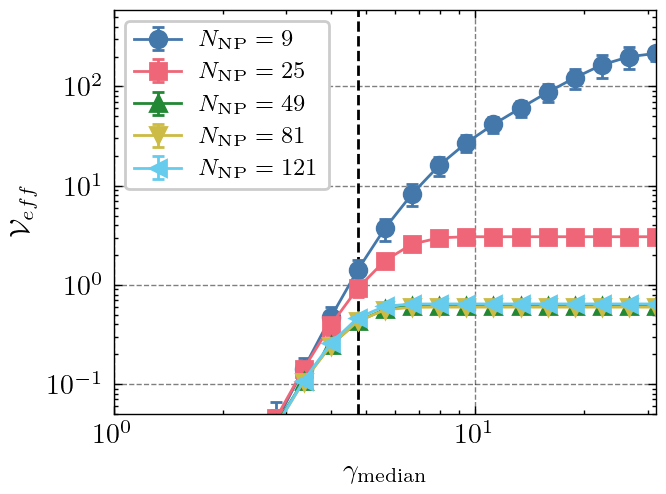

In [399]:
d_idx   = 9
mss     = ['o','s','^','v','<','>']
fig, ax = plt.subplots(dpi=200)
for i, N in enumerate(N_PARTICLES):
    # _   = ax.plot(d_factors, V_eff_dic[N], label="$N_\\textrm{NP} = "+f"{N**2}$")
    # _   = ax.errorbar(d_factors, V_eff_results[N]['boot_mean'], V_eff_results[N]['boot_std'], label="$N_\\textrm{NP} = "+f"{N**2}$", capsize=2, marker=mss[i])
    _   = ax.errorbar(d_factors, V_eff_stats[N]['mean'], V_eff_stats[N]['std']*1.96, label="$N_\\textrm{NP} = "+f"{N**2}$", capsize=2, marker=mss[i])
_   = ax.set_xlim(d_factors[0], d_factors[-1])
_   = plt.axvline(d_factors[d_idx], color='black', ls='--', zorder=0.1)
_   = ax.set_xlabel("$\gamma_\\textrm{median}$")
_   = ax.set_xscale('log')
_   = ax.set_ylabel("$\mathcal{V}_{eff}$")
_   = ax.legend(fontsize='small', loc='upper left')
_   = ax.set_yscale('log')
_   = ax.set_ylim(5e-2)

fig.savefig(f"plots/png/V_eff_vs_gamma_median_system_size.png", transparent=False)
fig.savefig(f"plots/pdf/V_eff_vs_gamma_median_system_size.pdf", transparent=False)
fig.savefig(f"plots/svg/V_eff_vs_gamma_median_system_size.svg", transparent=True)

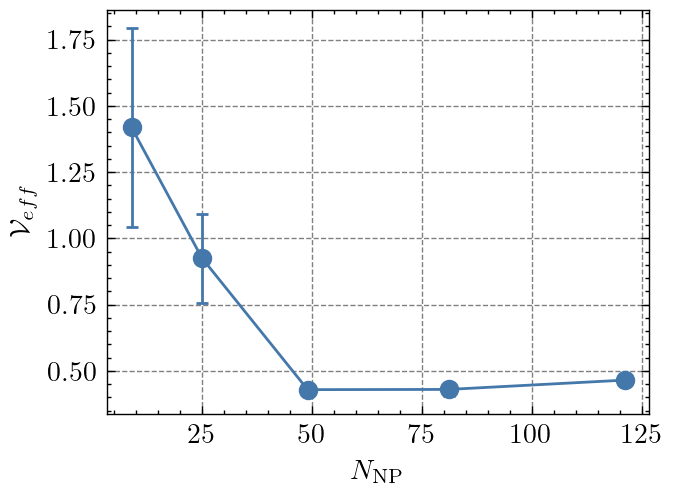

In [406]:
def power_law(x, a, c):
    return a*(x)**c

fig, ax = plt.subplots(dpi=200)
_       = ax.errorbar(np.array(N_PARTICLES)**2, [V_eff_stats[N]['mean'][d_idx] for N in N_PARTICLES], [V_eff_stats[N]['std'][d_idx]*1.96 for N in N_PARTICLES], marker='o', capsize=2)
# _       = ax.errorbar(np.array(N_PARTICLES)**2, [V_eff_results[N]['boot_mean'][d_idx] for N in N_PARTICLES], [V_eff_results[N]['boot_std'][d_idx] for N in N_PARTICLES], marker='o', capsize=2)
# p, c    = curve_fit(power_law, np.array(N_PARTICLES)**2, np.array([V_eff_results[N]['boot_mean'][d_idx] for N in N_PARTICLES])) 
# _       = ax.plot(np.array(N_PARTICLES)**2, power_law(np.array(N_PARTICLES)**2,*p))
# _       = ax.plot(np.array(N_PARTICLES)**2, [V_eff_results[N]['nominal'][d_idx] for N in N_PARTICLES], marker='o')
_       = ax.set_xlabel("$N_\\textrm{NP}$")
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
# _       = ax.set_xscale('log')
# _       = ax.set_yscale('log')

fig.savefig(f"plots/png/V_eff_vs_system_size.png", transparent=False)
fig.savefig(f"plots/pdf/V_eff_vs_system_size.pdf", transparent=False)
fig.savefig(f"plots/svg/V_eff_vs_system_size.svg", transparent=True)

KeyError: 3

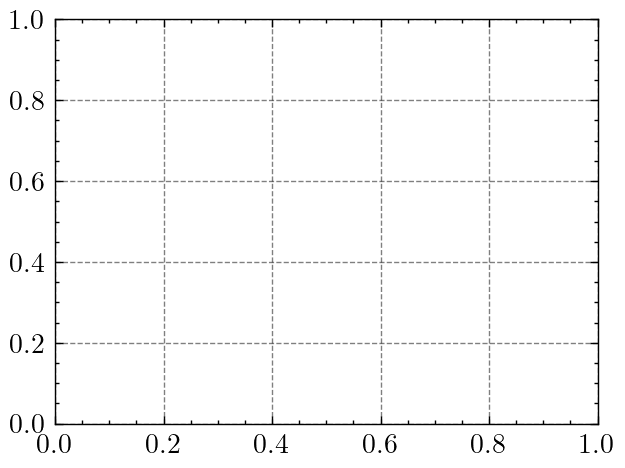

In [357]:
fig, ax = plt.subplots(dpi=200)
_       = ax.plot(np.array(N_PARTICLES)**2, [hulls[N] for N in N_PARTICLES], marker='o')
_       = ax.set_xlabel("$N_\\textrm{NP}$")
_       = ax.set_ylabel("$\mathcal{V}_{CH}$")
_       = ax.set_yscale('log')

# fig.savefig(f"plots/png/convex_hull_vol_vs_system_size.png", transparent=False)
# fig.savefig(f"plots/pdf/convex_hull_vol_vs_system_size.pdf", transparent=False)
# fig.savefig(f"plots/svg/convex_hull_vol_vs_system_size.svg", transparent=True)

### Phase

In [358]:
N_BOOT    = 500
data_boot = {}
for N in N_PARTICLES:
    data_boot[N] = []
    for i in range(N_SAMPLES):
        for _ in range(N_BOOT):
            data_boot[N].append(data_new[N][i]+np.random.normal(0,error_new[N][i]))

In [ ]:
# --- Configuration ---
phase_vectors   = {}
amp_vectors     = {}
dim             = 5
n_vals          = np.arange(2, dim + 1, 1)

# Get Phase
for N in N_PARTICLES:
    # phase_vectors[N] = np.array([extract_harmonic_features(data_new[N][i], n_vals, mode='phase', pad_len=8192, interpolate=True) 
    #                  for i in range(N_SAMPLES)])
    # amp_vectors[N]   = np.array([extract_harmonic_features(data_new[N][i], n_vals, mode='abs', pad_len=8192, interpolate=True) 
    #                  for i in range(N_SAMPLES)])
    phase_vectors[N] = np.array([extract_harmonic_features(data_boot[N][i], n_vals, mode='phase', pad_len=8192, interpolate=True) 
                     for i in range(N_SAMPLES*N_BOOT)])
    amp_vectors[N] = np.array([extract_harmonic_features(data_boot[N][i], n_vals, mode='abs', pad_len=8192, interpolate=True) 
                     for i in range(N_SAMPLES*N_BOOT)])
    
# Melt to df
phase_df    = pd.DataFrame()
phase_df2   = pd.DataFrame()
amp_df2     = pd.DataFrame()
for N in N_PARTICLES:
    df = pd.DataFrame(phase_vectors[N]).melt(var_name='n',value_name='phi')
    df['N'] = "$N_\\textrm{NP} ="+f" {N*N}$"
    phase_df = pd.concat([phase_df,df],ignore_index=True)

    phase_df2["$N_\\textrm{NP} ="+f" {N*N}$"] = phase_vectors[N].flatten()
    amp_df2["$N_\\textrm{NP} ="+f" {N*N}$"] = amp_vectors[N].flatten()

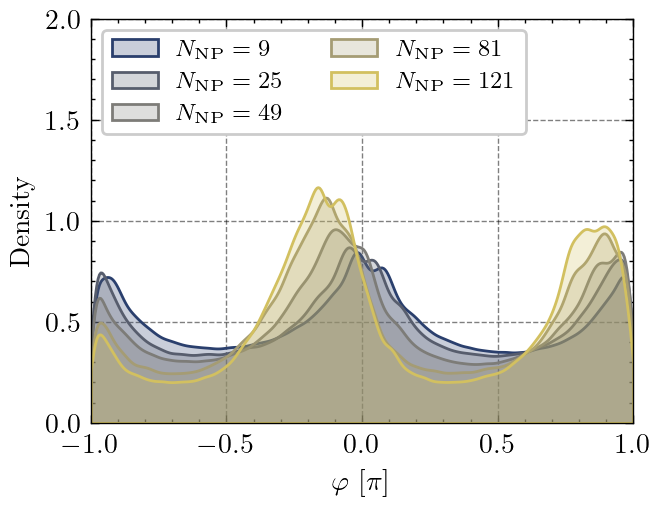

In [360]:
cp      = sns.color_palette('cividis', n_colors=len(N_PARTICLES))
fig, ax = plt.subplots(dpi=200)
for i, N in enumerate(N_PARTICLES):
    df  = pd.DataFrame({'a':phase_df2['$N_\\textrm{NP} = '+f'{N*N}$'].values,'b':amp_df2['$N_\\textrm{NP} = '+f'{N*N}$'].values})
    ax  = sns.kdeplot(data=df, x='a', ax=ax, weights='b', cut=0, fill=True, bw_adjust=0.5, gridsize=400, color=cp[i])

_ = ax.set_xlabel("$\\varphi~[\mathrm{\pi}]$")
_ = ax.set_xlim(-1,1)
_ = ax.set_ylim(0,2)

leg     = ax.legend(["$N_\\textrm{NP} ="+f" {N*N}$" for N in N_PARTICLES])
handles = leg.legend_handles
labels  = [t.get_text() for t in leg.get_texts()]
ax.legend(handles, labels, fontsize='small', loc='upper left', ncol=2)

# fig.savefig(f"plots/png/phase_vs_size.png", transparent=False)
# fig.savefig(f"plots/pdf/phase_vs_size.pdf", transparent=False)
# fig.savefig(f"plots/svg/phase_vs_size.svg", transparent=True)

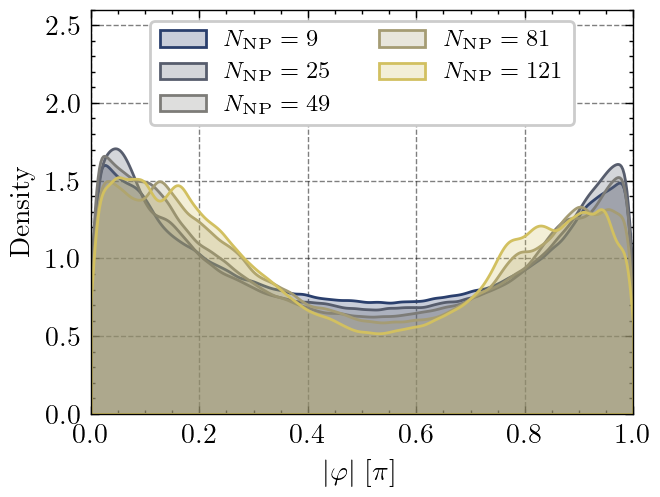

In [361]:
fig, ax = plt.subplots(dpi=200)
for i, N in enumerate(N_PARTICLES):
    df  = pd.DataFrame({'a':phase_df2['$N_\\textrm{NP} = '+f'{N*N}$'].abs().values,'b':amp_df2['$N_\\textrm{NP} = '+f'{N*N}$'].values})
    ax  = sns.kdeplot(data=df, x='a', ax=ax, weights='b', cut=0, fill=True, bw_adjust=0.5, gridsize=400, color=cp[i])

_ = ax.set_xlabel("$|\\varphi|~[\mathrm{\pi}]$")
_ = ax.set_xlim(0,1)
_ = ax.set_ylim(0,2.6)

leg     = ax.legend(["$N_\\textrm{NP} ="+f" {N*N}$" for N in N_PARTICLES])
handles = leg.legend_handles
labels  = [t.get_text() for t in leg.get_texts()]
ax.legend(handles, labels, fontsize='small', loc='upper center', ncol=2)

# fig.savefig(f"plots/png/abs_phase_vs_size.png", transparent=False)
# fig.savefig(f"plots/pdf/abs_phase_vs_size.pdf", transparent=False)
# fig.savefig(f"plots/svg/abs_phase_vs_size.svg", transparent=True)

### Nonlinear Metrics

In [366]:
hh_vectors  = {}
dim         = 5
d_factors   = np.logspace(-1,1,31)
n_vals      = np.arange(1,dim+1,1)
noise_floor = 1
for N in N_PARTICLES:
    # hh_vectors[N] = np.array([extract_harmonic_features(data_new[N][i],n_vals,mode='abs',pad_len=8192,interpolate=True) for i in range(N_SAMPLES)])
    hh_vectors[N] = np.array([extract_harmonic_features(data_boot[N][i],n_vals,mode='abs',pad_len=8192,interpolate=True) for i in range(N_SAMPLES*N_BOOT)])

centr_vals  = {N : [compute_spectral_centroid(hh_vectors[N][i], n_vals) for i in range(N_SAMPLES*N_BOOT) if hh_vectors[N][i,0] > noise_floor] for N in N_PARTICLES}
thd_vals    = {N : [compute_thd(hh_vectors[N][i]) for i in range(N_SAMPLES*N_BOOT) if hh_vectors[N][i,0] > noise_floor] for N in N_PARTICLES}

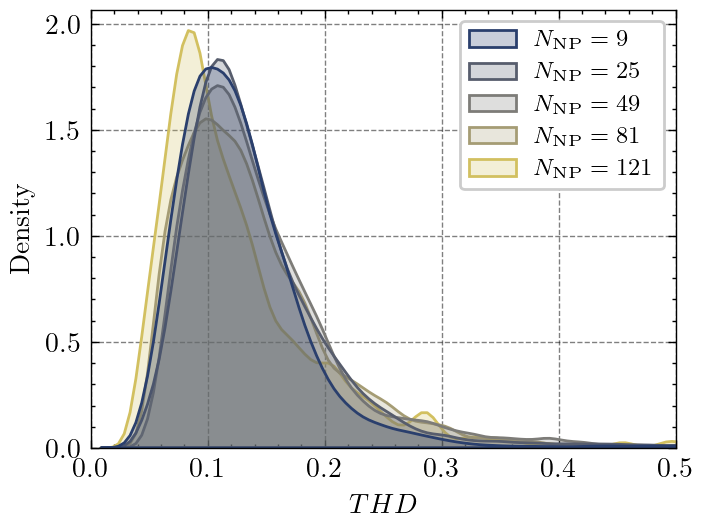

In [378]:
mss = ['o','s','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax  = sns.kdeplot(thd_vals, log_scale=False, palette='cividis', fill=True, ax=ax, common_grid=True, bw_adjust=1.0, clip=(0,1.0))
_   = ax.set_xlabel('$THD$')
_   = ax.set_xlim(0.0, 0.5)
# _   = ax.set_xscale('log')

# Legend Shit
leg     = ax.legend(["$N_\\textrm{NP} ="+f" {N*N}$" for N in N_PARTICLES[::-1]])
handles = leg.legend_handles
labels  = [t.get_text() for t in leg.get_texts()]
ax.legend(handles[::-1], labels[::-1], fontsize='small', loc='upper right', ncol=1)

fig.savefig("plots/png/THD_dist_vs_system_size.png", transparent=False)
fig.savefig("plots/pdf/THD_dist_vs_system_size.pdf", transparent=False)
fig.savefig("plots/svg/THD_dist_vs_system_size.svg", transparent=True)

In [379]:
cp  = sns.color_palette('cividis', n_colors=len(thd_vals.keys()))
mss = ['o','s','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
for i, (key, val) in enumerate(thd_vals.items()):
    x, ab   = data_abundance(val)
    _       = ax.plot(x, ab, label="$N_\\textrm{NP} = "+f"{key**2}$", marker=mss[i], markevery=0.05, c=cp[i])
_   = ax.legend(fontsize='small', ncol=1, loc='upper right')
_   = ax.set_xlabel('$THD$')
_   = ax.set_ylabel('Abundance')
_   = ax.set_xlim(0.05,0.8)
_   = ax.set_ylim(5,100)
_   = ax.set_xscale('log')
_   = ax.set_yscale('log')

fig.savefig("plots/png/THD_abundance_vs_system_size.png", transparent=False)
fig.savefig("plots/pdf/THD_abundance_vs_system_size.pdf", transparent=False)
fig.savefig("plots/svg/THD_abundance_vs_system_size.svg", transparent=True)

MemoryError: Unable to allocate 20.2 GiB for an array with shape (8977, 302515) and data type float64

MemoryError: Unable to allocate 20.2 GiB for an array with shape (8977, 302515) and data type float64

<Figure size 700x525 with 1 Axes>

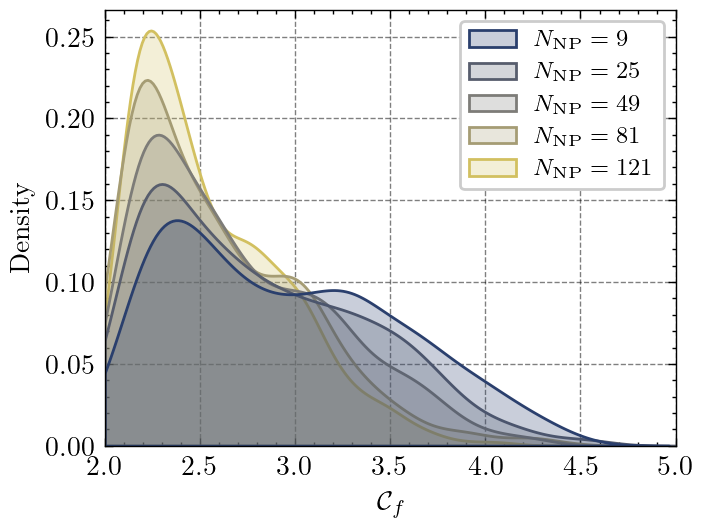

In [156]:
mss = ['o','s','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax  = sns.kdeplot(centr_vals, log_scale=False, palette='cividis', fill=True, ax=ax, clip=(2,5))
_   = ax.set_xlabel('$\mathcal{C}_f$')
_   = ax.set_xlim(2,5)

# Legend Shit
leg     = ax.legend(["$N_\\textrm{NP} ="+f" {N*N}$" for N in N_PARTICLES[::-1]])
handles = leg.legend_handles
labels  = [t.get_text() for t in leg.get_texts()]
ax.legend(handles[::-1], labels[::-1], fontsize='small', loc='upper right', ncol=1)

fig.savefig("plots/png/Cf_dist_vs_system_size.png", transparent=False)
fig.savefig("plots/pdf/Cf_dist_vs_system_size.pdf", transparent=False)
fig.savefig("plots/svg/Cf_dist_vs_system_size.svg", transparent=True)

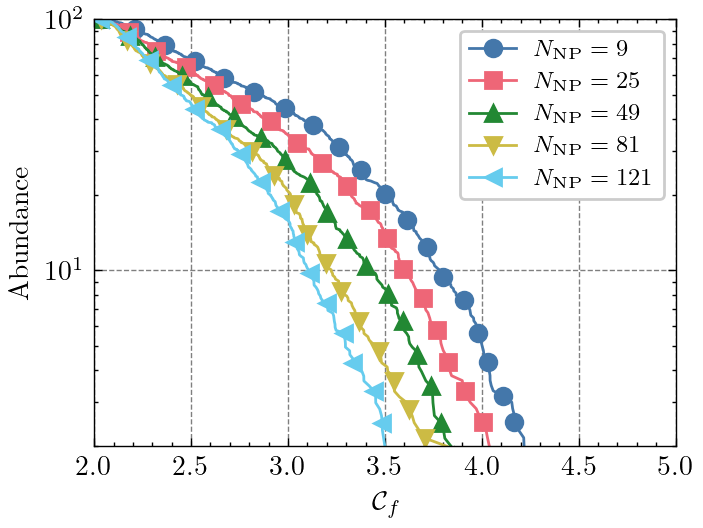

In [157]:
mss = ['o','s','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
for i, (key, val) in enumerate(centr_vals.items()):
    x, ab   = data_abundance(val)
    _       = ax.plot(x, ab, label="$N_\\textrm{NP} = "+f"{key**2}$", marker=mss[i], markevery=0.05)
_   = ax.legend(fontsize='small', ncol=1, loc='upper right')
_   = ax.set_xlabel('$\mathcal{C}_f$')
_   = ax.set_ylabel('Abundance')
_   = ax.set_xlim(2,5)
_   = ax.set_ylim(2,100)
_   = ax.set_yscale('log')

fig.savefig("plots/png/Cf_abundance_vs_system_size.png", transparent=False)
fig.savefig("plots/pdf/Cf_abundance_vs_system_size.pdf", transparent=False)
fig.savefig("plots/svg/Cf_abundance_vs_system_size.svg", transparent=True)

## Disorder

### from bagheera

In [478]:
index_vals      = [3,4,12,15,20,30]
f0_vals         = [1.0,5.0,18.0,28.0]

data_dis_1600   = {}
for n in index_vals:
    data_dis_1600_tmp = {}
    for f0 in f0_vals:
        data_dis_1600_tmp[f0] = {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_1600.0_{n}_{f0:.3f}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True) for i in range(N_SAMPLES)}
    data_dis_1600[n] = data_dis_1600_tmp

# for n in index_vals:
#     for f0 in f0_vals:
#         for i in range(N_SAMPLES):
#             data_dis_1600[n][f0][i].to_csv(f"data/data_dis_1600_{n}_{f0:.3f}_{i}.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/res_disorder_freq_manipulation/Nx=9_Ny=9_Ne=8_0_mean2_1600.0_3_1.000.csv'

### from local

In [176]:
index_vals      = [3,4,12,15,20,30]
f0_vals         = [1.0,5.0,18.0,28.0]
data_dis_1600   = {}
for n in index_vals:
    data_dis_1600_tmp = {}
    for f0 in f0_vals:
        data_dis_1600_tmp[f0] = {i : pd.read_csv(f"data/data_dis_1600_{n}_{f0:.3f}_{i}.csv") for i in range(N_SAMPLES)}
    data_dis_1600[n] = data_dis_1600_tmp

In [179]:
data_dis_1600_new = {}
error_dis_1600_new = {}
for n in index_vals:
    data_dis_1600_new[n] = {}
    error_dis_1600_new[n] = {}
    for f0 in f0_vals:
        data_dis_1600_new[n][f0] = [data_dis_1600[n][f0][i]['Observable'].values*1e-6 for i in range(N_SAMPLES)]
        error_dis_1600_new[n][f0] = [data_dis_1600[n][f0][i]['Error'].values*1e-6 for i in range(N_SAMPLES)]

In [180]:
idx_g = [12,3,4]
f0_g  = [18.0,28.0,1.0]
lab_g = ['Min $\\mathcal{G}$', 'Mid $\\mathcal{G}$', 'Max $\\mathcal{G}$']
idx_b = [15,30,20]
f0_b  = [5.0,28.0,28.0]
lab_b = ['Min $\\beta$','Mid $\\beta$','Max $\\beta$']

In [ ]:
# --- 1. Configuration ---
M_samples   = 200_000
dim         = 5
n_vals      = np.arange(1, dim + 1, 1)
d_factors   = np.logspace(0, 1.5, 61)

# Indices of disordered networks (Assuming these lists exist)
# idx_g = [...] 
# idx_b = [...]
indices_to_run = list(set(idx_g + idx_b))

# --- 2. Data Extraction & Normalization ---
print("Extracting features (Reference)...")
# Note: Explicitly use mode='complex'
hh_vectors_ref = np.array([extract_harmonic_features(data_new[9][i], n_vals, mode='complex', pad_len=8192, interpolate=True) 
                           for i in range(N_SAMPLES)])
# Normalize by Fundamental Amplitude (Re_H1 is at index 0)
hh_vectors_ref = hh_vectors_ref / hh_vectors_ref[:, 0, np.newaxis]
# Drop H1 (Keep indices 2 onwards)
hh_vectors_ref = hh_vectors_ref[:, 2:]

print("Extracting features (Disordered)...")
hh_vectors_dis = {}
for n in indices_to_run:
    hh_vectors_dis[n] = {}
    for f0 in f0_vals:
        # Extract
        raw_vecs = np.array([extract_harmonic_features(data_dis_1600_new[n][f0][i], n_vals, mode='complex', pad_len=8192, interpolate=True) 
                             for i in range(N_SAMPLES)])
        # Normalize
        norm_vecs = raw_vecs / raw_vecs[:, 0, np.newaxis]
        # Drop H1
        hh_vectors_dis[n][f0] = norm_vecs[:, 2:]

# --- 3. Compute Global Ruler (Median Distance) ---
print("Computing global ruler...")
# Stack data from Reference + All Disordered networks
dis_stack = np.vstack([np.vstack(list(hh_vectors_dis[n].values())) for n in indices_to_run])
all_data  = np.vstack([dis_stack, hh_vectors_ref])

# CRITICAL FIX: Subsample to avoid Memory Error with pdist
if len(all_data) > 10_000:
    idx_sub = np.random.choice(len(all_data), 10_000, replace=False)
    dist_subset = all_data[idx_sub]
else:
    dist_subset = all_data

pw_d_base = pdist(dist_subset)
pw_median = np.median(pw_d_base)
print(f"Global Median Distance: {pw_median:.4f}")

# --- 4. Parallel Worker Function ---
def worker_task_wrapper(args):
    """
    Unpacks arguments and runs volume calc.
    Args: (n, local_data_dict, f0_vals, d_factors, ruler, M)
    """
    n_id, local_data, f0_list, d_facs, ruler, M = args
    
    results = {}
    for f0 in f0_list:
        points = local_data[f0]
        
        # Define Fixed Bounding Box relative to this specific point cloud
        # Buffer of 2.0 * ruler ensures we don't clip saturation
        sys_min = points.min(axis=0) - 2.0 * ruler
        sys_max = points.max(axis=0) + 2.0 * ruler
        fixed_bounds = (sys_min, sys_max)
        
        V_effs = []
        for factor in d_facs:
            radius = factor * ruler
            # Using fixed bounds for all radii to observe saturation
            v = MC_effective_volume(points, M, radius, fixed_bounds)
            V_effs.append(v)
            
        results[f0] = V_effs
        
    return n_id, results

# --- 5. Execution ---
if __name__ == "__main__":
    # Prepare arguments for Pool
    # We pass the data dictionary for specific 'n' directly to avoid global lookup
    tasks = []
    for n in indices_to_run:
        task_args = (
            n, 
            hh_vectors_dis[n], 
            f0_vals, 
            d_factors, 
            pw_median, 
            M_samples
        )
        tasks.append(task_args)
    
    # Use Pool for cleaner management
    # processes=None defaults to os.cpu_count()
    print(f"Starting parallel pool with {len(tasks)} tasks...")
    
    with multiprocessing.Pool(processes=max(1, multiprocessing.cpu_count() - 1)) as pool:
        results_list = pool.map(worker_task_wrapper, tasks)
    
    # Reassemble results into dictionary
    V_eff_dis_dic = {n: res for n, res in results_list}
    print("Parallel processing complete.")

    # --- 6. Reference Calculation (Main Thread) ---
    print("Calculating Reference (9x9)...")
    V_effs_ref = []
    # Fixed bounds for reference
    ref_min = hh_vectors_ref.min(axis=0) - 2.0 * pw_median
    ref_max = hh_vectors_ref.max(axis=0) + 2.0 * pw_median
    ref_bounds = (ref_min, ref_max)
    
    for d_factor in d_factors:
        fixed_rad = d_factor * pw_median
        V_effs_ref.append(MC_effective_volume(hh_vectors_ref, M_samples, fixed_rad, ref_bounds))

Extracting features (Reference)...
Extracting features (Disordered)...
Computing global ruler...
Global Median Distance: 0.3102
Starting parallel pool with 6 tasks...
Parallel processing complete.
Calculating Reference (9x9)...


In [183]:
# --- 1. Configuration ---
M_samples       = 200_000 
dim             = 5
n_vals          = np.arange(1, dim + 1, 1)
n_bootstraps    = 10   # Number of resamplings per network/frequency combo
d_factors       = np.logspace(0, 1.5, 21) # Reduced points for speed, covers the saturation

# Indices (Assuming idx_g and idx_b exist in your workspace)
indices_to_run = list(set(idx_g + idx_b))

# --- 2. Data Extraction ---
print("Extracting features (Reference)...")
hh_vectors_ref = np.array([extract_harmonic_features(data_new[9][i], n_vals, mode='complex', pad_len=8192, interpolate=True) 
                           for i in range(N_SAMPLES)])
# Normalize and Drop H1
hh_vectors_ref = hh_vectors_ref / hh_vectors_ref[:, 0, np.newaxis]
hh_vectors_ref = hh_vectors_ref[:, 2:]

print("Extracting features (Disordered)...")
hh_vectors_dis = {}
for n in indices_to_run:
    hh_vectors_dis[n] = {}
    for f0 in f0_vals:
        raw_vecs = np.array([extract_harmonic_features(data_dis_1600_new[n][f0][i], n_vals, mode='complex', pad_len=8192, interpolate=True) 
                             for i in range(N_SAMPLES)])
        norm_vecs = raw_vecs / raw_vecs[:, 0, np.newaxis]
        hh_vectors_dis[n][f0] = norm_vecs[:, 2:]

# --- 3. Compute Global Ruler ---
print("Computing global ruler...")
dis_stack = np.vstack([np.vstack(list(hh_vectors_dis[n].values())) for n in indices_to_run])
all_data  = np.vstack([dis_stack, hh_vectors_ref])

if len(all_data) > 10_000:
    idx_sub = np.random.choice(len(all_data), 10_000, replace=False)
    dist_subset = all_data[idx_sub]
else:
    dist_subset = all_data

base_radius_unit = np.median(pdist(dist_subset))
print(f"Base Radius Unit: {base_radius_unit:.4f}")

# --- 4. Parallel Worker Function (Bootstrapped) ---
def worker_bootstrap_disordered(args):
    """
    Args: (n_id, local_data_dict, f0_list, d_factors, ruler, n_boot, M, seeds)
    Returns: (n_id, results_dict) where results_dict[f0] = {'mean': [], 'std': []}
    """
    n_id, local_data, f0_list, d_facs, ruler, n_boot, M, seeds = args
    
    # Store results for all frequencies of this network
    network_results = {}
    
    for f_idx, f0 in enumerate(f0_list):
        points_original = local_data[f0]
        seed = seeds[f_idx] # Unique seed per frequency
        rng = np.random.default_rng(seed)
        
        # Define Fixed Bounds for this specific cloud (Critical for stable volume)
        sys_min = points_original.min(axis=0)
        sys_max = points_original.max(axis=0)
        max_r = ruler
        fixed_bounds = (sys_min - max_r*2.0, sys_max + max_r*2.0)
        
        # Bootstrap Storage: (n_boot, n_radii)
        bootstrap_curves = np.zeros((n_boot, len(d_facs)))
        
        for b in range(n_boot):
            # Resample
            n_pts = len(points_original)
            resample_idx = rng.integers(0, n_pts, n_pts)
            points_resampled = points_original[resample_idx]
            
            # Sweep Radii
            for i, factor in enumerate(d_facs):
                radius = factor * ruler
                v = MC_effective_volume(points_resampled, M, radius, fixed_bounds)
                bootstrap_curves[b, i] = v
        
        # Compute Stats
        network_results[f0] = {
            'mean': np.mean(bootstrap_curves, axis=0),
            'std':  np.std(bootstrap_curves, axis=0)
        }
        
    return n_id, network_results

# --- 5. Execution ---
if __name__ == "__main__":
    tasks = []
    # Create one task per Network ID (handling all its frequencies inside)
    for n in indices_to_run:
        # Generate enough seeds for all frequencies
        seeds = np.random.randint(0, 10**9, len(f0_vals))
        
        task_args = (
            n, 
            hh_vectors_dis[n], 
            f0_vals, 
            d_factors, 
            base_radius_unit,
            n_bootstraps,
            M_samples,
            seeds
        )
        tasks.append(task_args)
    
    print(f"Starting pool for {len(tasks)} networks...")
    
    with multiprocessing.Pool(processes=max(1, multiprocessing.cpu_count() - 1)) as pool:
        results_list = pool.map(worker_bootstrap_disordered, tasks)
    
    V_eff_dis_dic = {n: res for n, res in results_list}
    print("Parallel processing complete.")

    # --- 6. Reference Calculation (Bootstrapped) ---
    print("Calculating Reference (9x9) with Bootstrap...")
    sys_min = hh_vectors_ref.min(axis=0)
    sys_max = hh_vectors_ref.max(axis=0)
    max_r = base_radius_unit
    ref_bounds = (sys_min - max_r*2.0, sys_max + max_r*2.0)
    
    ref_boot_curves = np.zeros((n_bootstraps, len(d_factors)))
    rng = np.random.default_rng(42)
    
    for b in range(n_bootstraps):
        idx = rng.integers(0, len(hh_vectors_ref), len(hh_vectors_ref))
        pts_res = hh_vectors_ref[idx]
        for i, factor in enumerate(d_factors):
            rad = factor * base_radius_unit
            ref_boot_curves[b, i] = MC_effective_volume(pts_res, M_samples, rad, ref_bounds)
            
    V_eff_ref_stats = {
        'mean': np.mean(ref_boot_curves, axis=0),
        'std': np.std(ref_boot_curves, axis=0)
    }

Extracting features (Reference)...
Extracting features (Disordered)...
Computing global ruler...
Base Radius Unit: 0.3135
Starting pool for 6 networks...
Parallel processing complete.
Calculating Reference (9x9) with Bootstrap...


3.9810717055349722


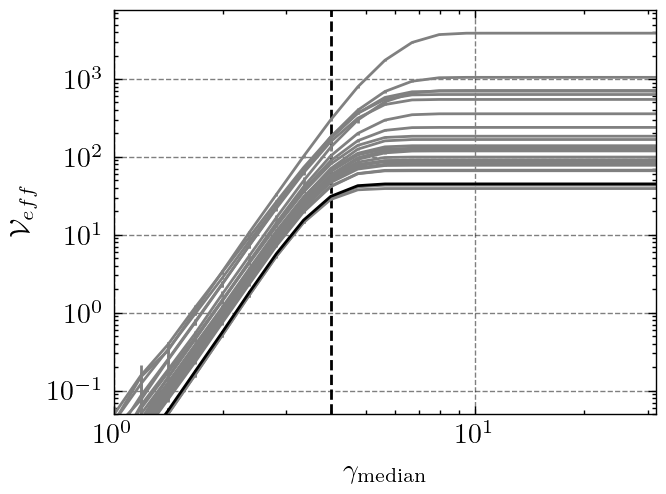

In [214]:
d_idx   = 8
fig, ax = plt.subplots(dpi=200)
print(d_factors[d_idx])
for n in index_vals:
    for f0 in f0_vals:
        # _ = ax.plot(d_factors, V_eff_dis_dic[n][f0], c='grey')
        _ = ax.errorbar(d_factors, V_eff_dis_dic[n][f0]['mean'], V_eff_dis_dic[n][f0]['std'], c='grey')
_   = ax.errorbar(d_factors, V_eff_ref_stats['mean'], V_eff_ref_stats['std'], c='black')
_   = plt.axvline(d_factors[d_idx], color='black', ls='--', zorder=0.1)
_   = ax.set_xlim(d_factors[0], d_factors[-1])
_   = ax.set_xlabel("$\gamma_\\textrm{median}$")
_   = ax.set_xscale('log')
_   = ax.set_yscale('log')
_   = ax.set_ylabel("$\mathcal{V}_{eff}$")
_   = ax.set_ylim(5e-2)

In [221]:
V_eff_dis_df_mean = pd.DataFrame([[V_eff_dis_dic[n][f0]['mean'][d_idx] for f0 in f0_vals] for n in idx_g+idx_b], columns=f0_vals, index=lab_g+lab_b)
V_eff_dis_df_std = pd.DataFrame([[V_eff_dis_dic[n][f0]['std'][d_idx] for f0 in f0_vals] for n in idx_g+idx_b], columns=f0_vals, index=lab_g+lab_b)

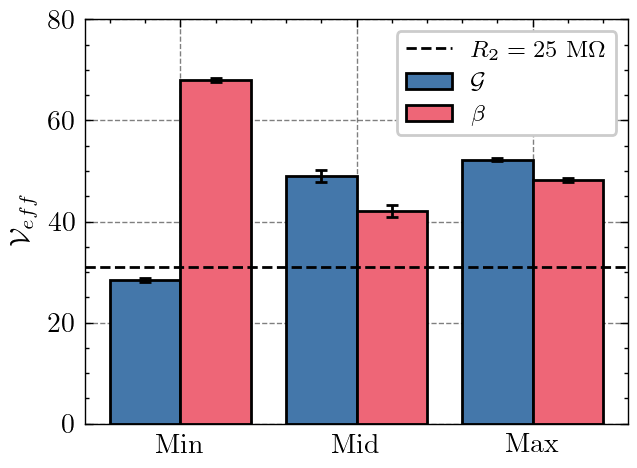

In [235]:
fig, ax = plt.subplots(dpi=200)
f0      = 28.0
_       = ax.bar(['Min','Mid','Max'], V_eff_dis_df_mean.loc[lab_g,f0].values, yerr=V_eff_dis_df_std.loc[lab_g,f0].values,
                 label='$\\mathcal{G}$', align='edge', width=-0.4, edgecolor='black', capsize=2)
_       = ax.bar(['Min','Mid','Max'], V_eff_dis_df_mean.loc[lab_b,f0].values, yerr=V_eff_dis_df_std.loc[lab_g,f0].values,
                 label='$\\beta$', align='edge', width=0.4, edgecolor='black', capsize=2)
_       = plt.axhline(y=V_eff_ref_stats['mean'][d_idx], color='black', ls='dashed', label='$R_2 = 25~\mathrm{M\Omega}$')
_       = ax.legend(fontsize='small', loc='upper right')
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.set_ylim(0,80)

fig.savefig(f"plots/png/V_eff_disorder_at_28.png", transparent=False)
fig.savefig(f"plots/pdf/V_eff_disorder_at_28.pdf", transparent=False)
fig.savefig(f"plots/svg/V_eff_disorder_at_28.svg", transparent=True)

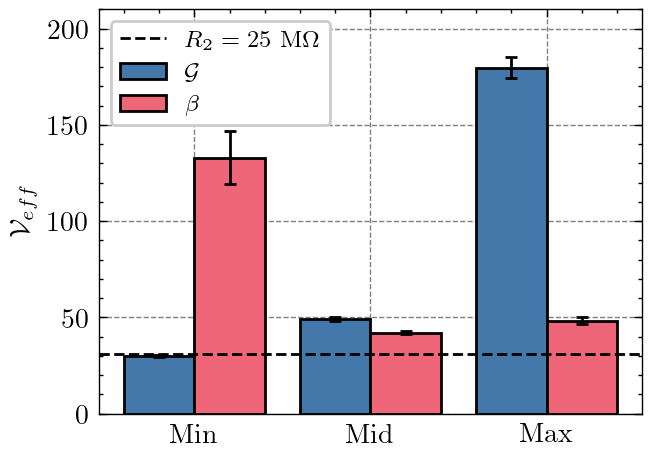

In [234]:
fig, ax = plt.subplots(dpi=200)
_       = ax.bar(['Min','Mid','Max'], V_eff_dis_df_mean.to_numpy()[V_eff_dis_df_mean.index.get_indexer(lab_g), V_eff_dis_df_mean.columns.get_indexer(f0_g)],
                 yerr=V_eff_dis_df_std.to_numpy()[V_eff_dis_df_std.index.get_indexer(lab_g), V_eff_dis_df_std.columns.get_indexer(f0_g)],
                 label='$\\mathcal{G}$', align='edge', width=-0.4, edgecolor='black', capsize=2)
_       = ax.bar(['Min','Mid','Max'], V_eff_dis_df_mean.to_numpy()[V_eff_dis_df_mean.index.get_indexer(lab_b), V_eff_dis_df_mean.columns.get_indexer(f0_b)],
                 yerr=V_eff_dis_df_std.to_numpy()[V_eff_dis_df_std.index.get_indexer(lab_b), V_eff_dis_df_std.columns.get_indexer(f0_b)],
                 label='$\\beta$', align='edge', width=0.4, edgecolor='black', capsize=2)
_       = plt.axhline(y=V_eff_ref_stats['mean'][d_idx], color='black', ls='dashed', label='$R_2 = 25~\mathrm{M\Omega}$')
_       = ax.legend(fontsize='small')
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")
_       = ax.set_ylim(0,210)

fig.savefig(f"plots/png/V_eff_disorder_at_max_f0.png", transparent=False)
fig.savefig(f"plots/pdf/V_eff_disorder_at_max_f0.pdf", transparent=False)
fig.savefig(f"plots/svg/V_eff_disorder_at_max_f0.svg", transparent=True)

### Phase

In [ ]:
# --- Configuration ---
phase_vectors   = {}
amp_vectors     = {}
M_samples       = 200_000 
dim             = 5
n_vals          = np.arange(2, dim + 1, 1)

# Get Phase
for n in idx_g+idx_b:
    phase_vectors[n] = {}
    amp_vectors[n] = {}
    for f0 in f0_vals:
        phase_vectors[n][f0] = np.array([extract_harmonic_features(data_dis_1600_new[n][f0][i], n_vals, mode='phase', pad_len=8192, interpolate=True) 
                                         for i in range(N_SAMPLES)])
        amp_vectors[n][f0] = np.array([extract_harmonic_features(data_dis_1600_new[n][f0][i], n_vals, mode='abs', pad_len=8192, interpolate=True) 
                                         for i in range(N_SAMPLES)])

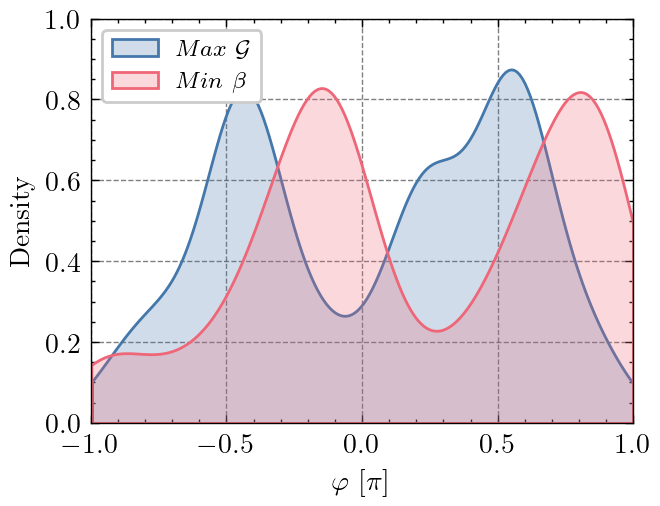

In [274]:
fig, ax = plt.subplots(dpi=200)
df      = pd.DataFrame({'a':phase_vectors[idx_g[-1]][28.0].flatten(),'b':amp_vectors[idx_g[-1]][28.0].flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=BLUE_COLOR, fill=True, label="$Max~\\mathcal{G}$")
df      = pd.DataFrame({'a':phase_vectors[idx_b[0]][28.0].flatten(),'b':amp_vectors[idx_b[0]][28.0].flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=RED_COLOR, fill=True, label="$Min~\\beta$")
_       = ax.set_xlim(-1,1)
_       = ax.set_ylim(0,1)
_       = ax.set_xlabel("$\\varphi~[\mathrm{\pi}]$")
_       = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/phase_of_max_gain_vs_min_beta_.png", transparent=False)
fig.savefig(f"plots/pdf/phase_of_max_gain_vs_min_beta_.pdf", transparent=False)
fig.savefig(f"plots/svg/phase_of_max_gain_vs_min_beta_.svg", transparent=True)

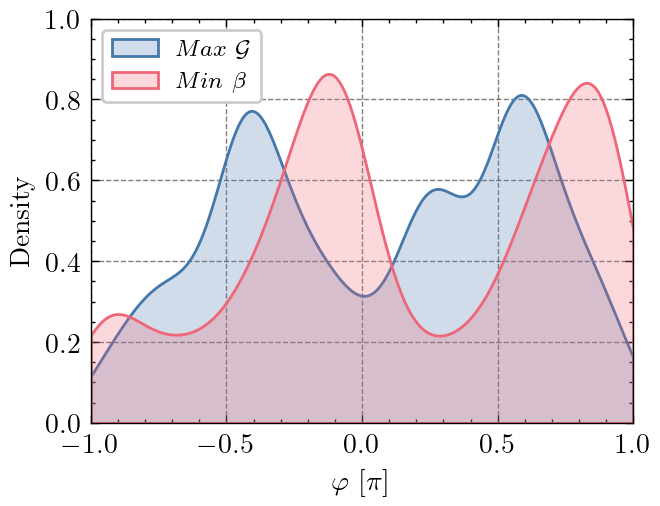

In [288]:
fig, ax = plt.subplots(dpi=200)
df      = pd.DataFrame({'a':np.array([phase_vectors[idx_g[-1]][f0] for f0 in f0_vals]).flatten(),
                        'b':np.array([amp_vectors[idx_g[-1]][f0] for f0 in f0_vals]).flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=BLUE_COLOR, fill=True, label="$Max~\\mathcal{G}$", bw_adjust=1.0)
df      = pd.DataFrame({'a':np.array([phase_vectors[idx_b[0]][f0] for f0 in f0_vals]).flatten(),
                        'b':np.array([amp_vectors[idx_b[0]][f0] for f0 in f0_vals]).flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=RED_COLOR, fill=True, label="$Min~\\beta$", bw_adjust=1.0)
_       = ax.set_xlim(-1,1)
_       = ax.set_ylim(0,1)
_       = ax.set_xlabel("$\\varphi~[\mathrm{\pi}]$")
_       = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/phase_of_max_gain_vs_min_beta_.png", transparent=False)
fig.savefig(f"plots/pdf/phase_of_max_gain_vs_min_beta_.pdf", transparent=False)
fig.savefig(f"plots/svg/phase_of_max_gain_vs_min_beta_.svg", transparent=True)

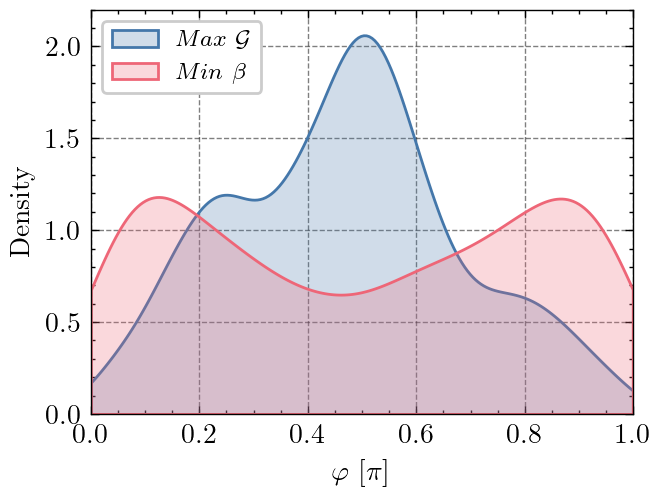

In [292]:
fig, ax = plt.subplots(dpi=200)
# df      = pd.DataFrame({'a':phase_df2["$N_\\textrm{NP} = 81$"].abs(),'b':amp_df2["$N_\\textrm{NP} = 81$"]})
# ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color='grey', fill=True, label='$R_2 = 25~\mathrm{M\Omega}$')
df      = pd.DataFrame({'a':np.abs(phase_vectors[idx_g[-1]][28.0].flatten()),'b':amp_vectors[idx_g[-1]][28.0].flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=BLUE_COLOR, fill=True, label="$Max~\\mathcal{G}$")
df      = pd.DataFrame({'a':np.abs(phase_vectors[idx_b[0]][28.0].flatten()),'b':amp_vectors[idx_b[0]][28.0].flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=RED_COLOR, fill=True, label="$Min~\\beta$")
_       = ax.set_xlim(0,1)
_       = ax.set_ylim(0,2.2)
_       = ax.set_xlabel("$\\varphi~[\mathrm{\pi}]$")
_       = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/abs_phase_of_max_gain_vs_min_beta_.png", transparent=False)
fig.savefig(f"plots/pdf/abs_phase_of_max_gain_vs_min_beta_.pdf", transparent=False)
fig.savefig(f"plots/svg/abs_phase_of_max_gain_vs_min_beta_.svg", transparent=True)

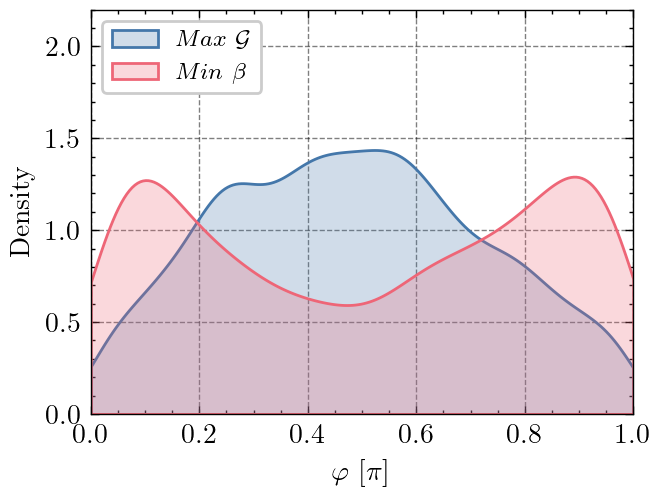

In [291]:
fig, ax = plt.subplots(dpi=200)
df      = pd.DataFrame({'a':np.abs(np.array([phase_vectors[idx_g[-1]][f0] for f0 in f0_vals]).flatten()),
                        'b':np.array([amp_vectors[idx_g[-1]][f0] for f0 in f0_vals]).flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=BLUE_COLOR, fill=True, label="$Max~\\mathcal{G}$", bw_adjust=1.0)
df      = pd.DataFrame({'a':np.abs(np.array([phase_vectors[idx_b[0]][f0] for f0 in f0_vals]).flatten()),
                        'b':np.array([amp_vectors[idx_b[0]][f0] for f0 in f0_vals]).flatten()})
ax      = sns.kdeplot(data=df, x='a', weights='b', cut=0, ax=ax, color=RED_COLOR, fill=True, label="$Min~\\beta$", bw_adjust=1.0)
_       = ax.set_xlim(0,1)
_       = ax.set_ylim(0,2.2)
_       = ax.set_xlabel("$\\varphi~[\mathrm{\pi}]$")
_       = ax.legend(fontsize='small', loc='upper left')

fig.savefig(f"plots/png/abs_phase_of_max_gain_vs_min_beta_.png", transparent=False)
fig.savefig(f"plots/pdf/abs_phase_of_max_gain_vs_min_beta_.pdf", transparent=False)
fig.savefig(f"plots/svg/abs_phase_of_max_gain_vs_min_beta_.svg", transparent=True)

### Nonlinear

In [334]:
hh_vectors_dis  = {}
thd_vals_dis    = {}
centr_vals_dis  = {}
M_samples       = 200000
dim             = 9
d_factors       = np.logspace(-1,1,31)
n_vals          = np.arange(1,dim+1,1)
hh_vectors_ref  = np.array([extract_harmonic_features(data_new[9][i],n_vals,mode='abs',pad_len=8192,interpolate=True) for i in range(N_SAMPLES)])
for n in idx_g+idx_b:
    hh_vectors_dis[n] = {f0 : np.array([extract_harmonic_features(data_dis_1600_new[n][f0][i],n_vals,mode='abs',pad_len=8192,interpolate=True) for i in range(N_SAMPLES)]) for f0 in f0_vals}
for n in idx_g+idx_b:
    thd_vals_dis[n]     = {f0 : [compute_thd(hh_vectors_dis[n][f0][i]) for i in range(N_SAMPLES) if hh_vectors_dis[n][f0][i,0] > noise_floor] for f0 in f0_vals}
    centr_vals_dis[n]   = {f0 : [compute_spectral_centroid(hh_vectors_dis[n][f0][i], n_vals) for i in range(N_SAMPLES) if hh_vectors_dis[n][f0][i,0] > noise_floor] for f0 in f0_vals}

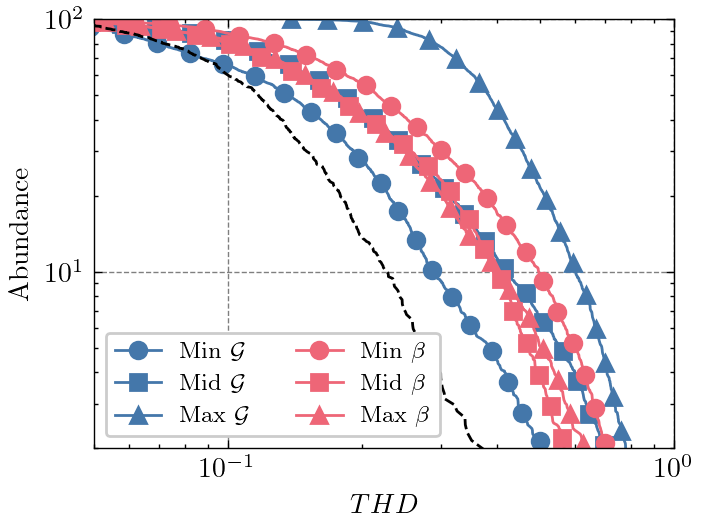

In [346]:
mss = ['o','s','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()

for i, key in enumerate(idx_g):
    x, ab   = data_abundance(np.hstack([thd_vals_dis[key][f0] for f0 in f0_vals]))
    _       = ax.plot(x, ab, label=lab_g[i], marker=mss[i], markevery=0.05, color=BLUE_COLOR)

for i, key in enumerate(idx_b):
    x, ab   = data_abundance(np.hstack([thd_vals_dis[key][f0] for f0 in f0_vals]))
    _       = ax.plot(x, ab, label=lab_b[i], marker=mss[i], markevery=0.05, color=RED_COLOR)

x, ab   = data_abundance(thd_vals[9])
_       = ax.plot(x, ab, markevery=0.05, color='black', ls='--')#, label='$R_2 = 25~\mathrm{M\Omega}$')

_   = ax.legend(fontsize='small', ncol=2, loc='lower left')
_   = ax.set_xlabel('$THD$')
_   = ax.set_ylabel('Abundance')
_   = ax.set_xlim(0.05,1)
_   = ax.set_ylim(2,100)
_   = ax.set_xscale('log')
_   = ax.set_yscale('log')

fig.savefig(f"plots/png/THD_abundance_disorder.png", transparent=False)
fig.savefig(f"plots/pdf/THD_abundance_disorder.pdf", transparent=False)
fig.savefig(f"plots/svg/THD_abundance_disorder.svg", transparent=True)

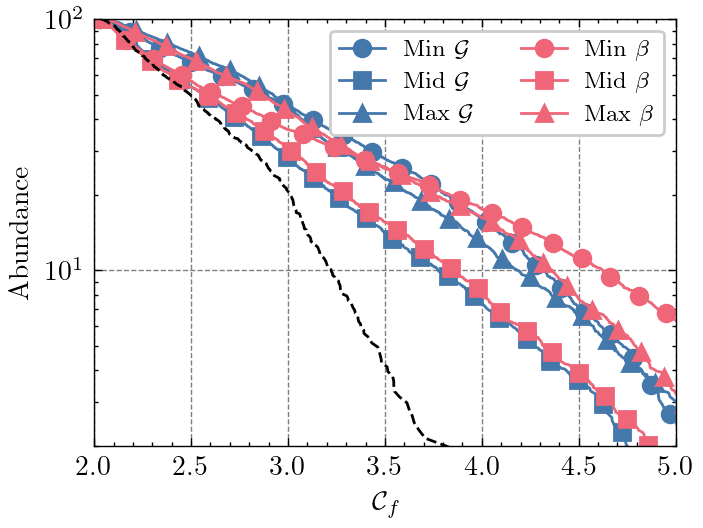

In [347]:
mss = ['o','s','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()

for i, key in enumerate(idx_g):
    x, ab   = data_abundance(np.hstack([centr_vals_dis[key][f0] for f0 in f0_vals]))
    _       = ax.plot(x, ab, label=lab_g[i], marker=mss[i], markevery=0.05, color=BLUE_COLOR)

for i, key in enumerate(idx_b):
    x, ab   = data_abundance(np.hstack([centr_vals_dis[key][f0] for f0 in f0_vals]))
    _       = ax.plot(x, ab, label=lab_b[i], marker=mss[i], markevery=0.05, color=RED_COLOR)

x, ab   = data_abundance(centr_vals[9])
_       = ax.plot(x, ab, markevery=0.05, color='black', ls='--')#, label='$R_2 = 25~\mathrm{M\Omega}$')

_   = ax.legend(fontsize='small', ncol=2, loc='upper right')
_   = ax.set_xlabel('$\mathcal{C}_f$')
_   = ax.set_ylabel('Abundance')
_   = ax.set_xlim(2,5)
_   = ax.set_ylim(2,100)
_   = ax.set_yscale('log')

fig.savefig(f"plots/png/Cf_abundance_disorder.png", transparent=False)
fig.savefig(f"plots/pdf/Cf_abundance_disorder.pdf", transparent=False)
fig.savefig(f"plots/svg/Cf_abundance_disorder.svg", transparent=True)

In [305]:
# mss = ['o','s','^','v','<','>']
# fig = plt.figure(dpi=200, layout='constrained')
# ax  = fig.add_subplot()
# f0  = 28.0

# for i, key in enumerate(idx_g):
#     x, ab   = data_abundance(thd_vals_dis[key][f0])
#     _       = ax.plot(x, ab, label=lab_g[i], marker=mss[i], markevery=0.05, color=BLUE_COLOR)

# for i, key in enumerate(idx_b):
#     x, ab   = data_abundance(thd_vals_dis[key][f0])
#     _       = ax.plot(x, ab, label=lab_b[i], marker=mss[i], markevery=0.05, color=RED_COLOR)

# x, ab   = data_abundance(thd_vals[9])
# _       = ax.plot(x, ab, markevery=0.05, color='black', ls='--')#, label='$R_2 = 25~\mathrm{M\Omega}$')

# _   = ax.legend(fontsize='small', ncol=2, loc='lower left')
# _   = ax.set_xlabel('$THD$')
# _   = ax.set_ylabel('Abundance')
# _   = ax.set_xlim(0.05,1)
# _   = ax.set_ylim(2,100)
# _   = ax.set_xscale('log')
# _   = ax.set_yscale('log')

# fig.savefig(f"plots/png/THD_abundance_disorder_at_28.png", transparent=False)
# fig.savefig(f"plots/pdf/THD_abundance_disorder_at_28.pdf", transparent=False)
# fig.savefig(f"plots/svg/THD_abundance_disorder_at_28.svg", transparent=True)

In [304]:
# mss = ['o','s','^','v','<','>']
# fig = plt.figure(dpi=200, layout='constrained')
# ax  = fig.add_subplot()

# for i, key in enumerate(idx_g):
#     x, ab   = data_abundance(thd_vals_dis[key][f0_g[i]])
#     _       = ax.plot(x, ab, label=lab_g[i], marker=mss[i], markevery=0.05, color=BLUE_COLOR)

# for i, key in enumerate(idx_b):
#     x, ab   = data_abundance(thd_vals_dis[key][f0_b[i]])
#     _       = ax.plot(x, ab, label=lab_b[i], marker=mss[i], markevery=0.05, color=RED_COLOR)

# x, ab   = data_abundance(thd_vals[9])
# _       = ax.plot(x, ab, markevery=0.05, color='black', ls='--')#, label='$R_2 = 25~\mathrm{M\Omega}$')

# _   = ax.legend(fontsize='small', ncol=2, loc='lower left')
# _   = ax.set_xlabel('$THD$')
# _   = ax.set_ylabel('Abundance')
# _   = ax.set_xlim(0.05,1)
# _   = ax.set_ylim(2,100)
# _   = ax.set_xscale('log')
# _   = ax.set_yscale('log')

# fig.savefig(f"plots/png/THD_abundance_disorder_at_max_f0.png", transparent=False)
# fig.savefig(f"plots/pdf/THD_abundance_disorder_at_max_f0.pdf", transparent=False)
# fig.savefig(f"plots/svg/THD_abundance_disorder_at_max_f0.svg", transparent=True)

In [348]:
f0_vals

[1.0, 5.0, 18.0, 28.0]

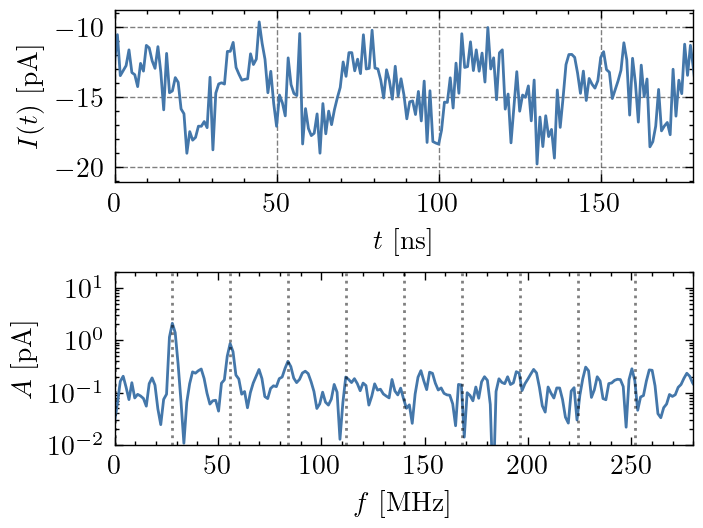

In [349]:
f0          = 1.0
i_at        = 2
max_thd_i   = np.argmax(thd_vals_dis[idx_g[i_at]][f0])
y_val       = data_dis_1600_new[idx_g[i_at]][f0][max_thd_i]
t_val       = np.arange(len(y_val))*DT

fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot(2,1,1)
_       = ax.plot(t_val*1e9, y_val)
_       = ax.set_xlim(0,t_val[SAMPLE_P_PERIOD*5]*1e9)
_       = ax.set_xlabel("$t$ [ns]")
_       = ax.set_ylabel("$I(t)$ [pA]")
ax      = fig.add_subplot(2,1,2)
xf, yf  = get_frequency_spectrum(y_val, DT)
_       = ax.semilogy(xf*1e-6, yf)
_       = ax.set_ylabel('$A$ [pA]')
_       = ax.set_xlim(0,10*F0)
_       = ax.set_ylim(0.01,20)
_       = ax.grid(False)
_       = ax.set_xlabel("$f$ [MHz]")
for n in range(10):
    plt.axvline(n*F0, color='black', ls=':', alpha=0.5)

# fig.savefig("plots/png/example_response.png", transparent=False)
# fig.savefig("plots/pdf/example_response.pdf", transparent=False)
# fig.savefig("plots/svg/example_response.svg", transparent=True)

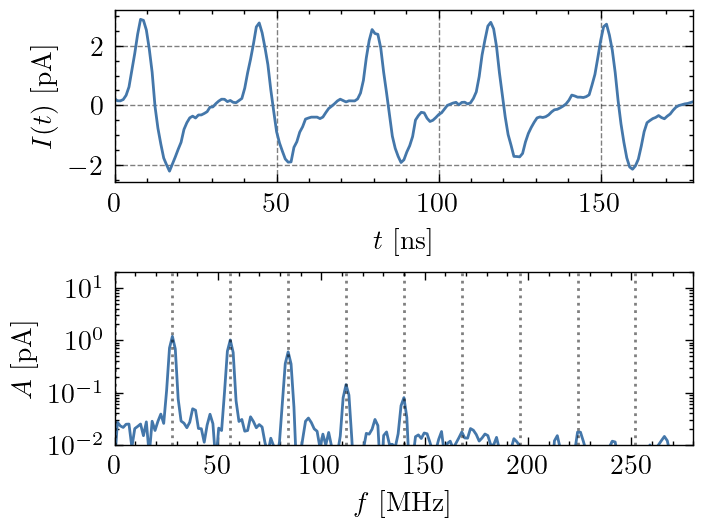

In [326]:
f0          = 28.0
i_at        = 0
max_thd_i   = np.argmax(thd_vals_dis[idx_b[i_at]][f0])
y_val       = data_dis_1600_new[idx_b[i_at]][f0][max_thd_i]
t_val       = np.arange(len(y_val))*DT

fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot(2,1,1)
_       = ax.plot(t_val*1e9, y_val)
_       = ax.set_xlim(0,t_val[SAMPLE_P_PERIOD*5]*1e9)
_       = ax.set_xlabel("$t$ [ns]")
_       = ax.set_ylabel("$I(t)$ [pA]")
ax      = fig.add_subplot(2,1,2)
xf, yf  = get_frequency_spectrum(y_val, DT)
_       = ax.semilogy(xf*1e-6, yf)
_       = ax.set_ylabel('$A$ [pA]')
_       = ax.set_xlim(0,10*F0)
_       = ax.set_ylim(0.01,20)
_       = ax.grid(False)
_       = ax.set_xlabel("$f$ [MHz]")
for n in range(10):
    plt.axvline(n*F0, color='black', ls=':', alpha=0.5)

### Control Voltages

In [34]:
ctrl_volt = {N : np.array([data[N][i].loc[0,"E1":"E6"].round(6).values for i in range(N_SAMPLES)])}

In [4]:
R_VALUES    = [50.0,100.0,200.0,400.0,800.0,1600.0]
N_SAMPLES_R = 608
data_R_15   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_15.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}
data_R_10   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_10.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}
data_R_19   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_19.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}

In [5]:
N_SAMPLES   = 608
data_3      = {i : pd.read_csv(f"{PATH}Nx=3_Ny=3_Ne=8_{i}.csv") for i in range(N_SAMPLES)}
data_9      = {i : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{i}.csv") for i in range(N_SAMPLES)}
data_new_3  = [data_3[i].iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES)]
data_new_9  = [data_9[i].iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES)]

In [6]:
dim             = 2
n_vals          = np.arange(1,dim+1,1)
hh_vector_3     = np.array([hh_amplitudes(data_new_3[i], n_vals) for i in range(N_SAMPLES)])
hh_vector_9     = np.array([hh_amplitudes(data_new_9[i], n_vals) for i in range(N_SAMPLES)])

### Convex Hull

45.90216780360559
93.94471801328905


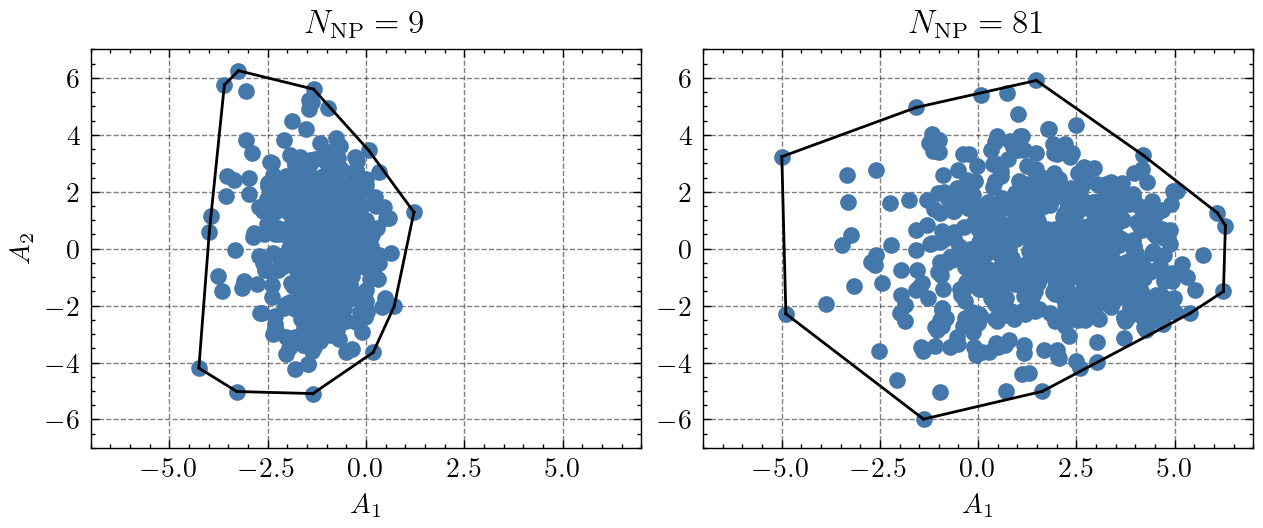

In [8]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

hull    = ConvexHull(hh_vector_3)
V_hull  = hull.volume
print(V_hull)
ax1.plot(hh_vector_3[:,0], hh_vector_3[:,1], 'o', ms=5)
for simplex in hull.simplices:
    ax1.plot(hh_vector_3[simplex, 0], hh_vector_3[simplex, 1], 'k-')
ax1.set_xlim(-7,7)
ax1.set_ylim(-7,7)
# ax1.set_xlim(0,50)
ax1.set_title("$N_\\textrm{NP} = 9$")
ax1.set_xlabel("$A_1$")
ax1.set_ylabel("$A_2$")

hull    = ConvexHull(hh_vector_9)
V_hull  = hull.volume
print(V_hull)
ax2.plot(hh_vector_9[:,0], hh_vector_9[:,1], 'o', ms=5)
for simplex in hull.simplices:
    ax2.plot(hh_vector_9[simplex, 0], hh_vector_9[simplex, 1], 'k-')
ax2.set_xlim(-7,7)
ax2.set_ylim(-7,7)
ax2.set_title("$N_\\textrm{NP} = 81$")
ax2.set_xlabel("$A_1$")

fig.savefig("plots/png/enclosed_area_comp.png", transparent=False)
fig.savefig("plots/pdf/enclosed_area_comp.pdf", transparent=False)
fig.savefig("plots/svg/enclosed_area_comp.svg", transparent=True)